In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,Activation
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [2]:

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1.0/255)


validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [11]:
batch_size = 64
target_size = (64, 64)
input_shape = (64, 64, 3)
seed = 1337
adam_lr = 0.0001
epochs = 10
patience = 5

In [4]:
train_generator = train_datagen.flow_from_directory('./GenderDataset/train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( './GenderDataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 135096 images belonging to 2 classes.
Found 16886 images belonging to 2 classes.


In [5]:
# Load the pre-trained VGG16 model without the top layers
from tensorflow.keras.applications import VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

In [6]:
# Freeze the layers up to the last convolutional block
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Build the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [8]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=adam_lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('genderClassificationUpgrade1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)


In [12]:
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr, checkpoint, early_stop]
)

C:\Users\HP\AppData\Local\Temp\ipykernel_17388\2963743779.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
2111/2111 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8125
Epoch 1: val_accuracy improved from -inf to 0.87297, saving model to genderClassificationUpgrade1.h5
2111/2111 [==============================] - 3602s 2s/step - loss: 0.4245 - accuracy: 0.8125 - val_loss: 0.3017 - val_accuracy: 0.8730 - lr: 1.0000e-04
Epoch 2/10
2111/2111 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8323
Epoch 2: val_accuracy improved from 0.87297 to 0.87309, saving model to genderClassificationUpgrade1.h5
2111/2111 [==============================] - 3833s 2s/step - loss: 0.3769 - accuracy: 0.8323 - val_loss: 0.2963 - val_accuracy: 0.8731 - lr: 1.0000e-04
Epoch 3/10
2111/2111 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8384
Epoch 3: val_accuracy improved from 0.87309 to 0.87771, saving model to genderClassificationUpgrade1.h5
2111/2111 [==============================] - 3565s 2s/step - loss: 0.3638 - accuracy: 0.8384 

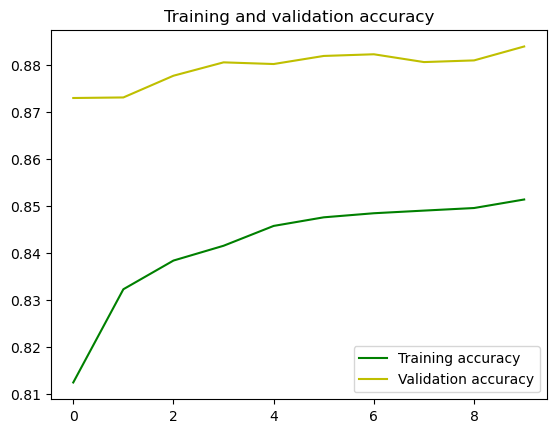

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 63ms/step
Predicted class: female
Probability: [0.40258712]


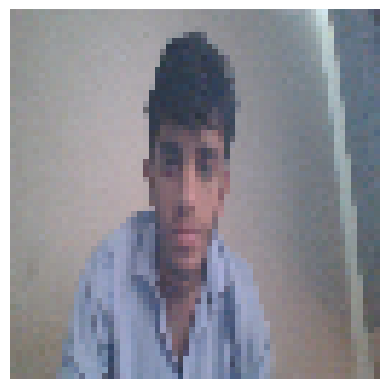

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img = './image/hassan.jpg'
imge = image.load_img(img, target_size=target_size)
X = image.img_to_array(imge) / 255.0  # Normalize the image
X = np.expand_dims(X, axis=0)

# Make predictions on the image
predictions = model.predict(X)

# Define the threshold for classification
threshold = 0.5

# Class labels
class_labels = ["female", "male"]

# Get the predicted class index
predicted_class_index = 1 if predictions[0] > threshold else 0

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and the corresponding probability
print("Predicted class:", predicted_class_label)
print("Probability:", predictions[0])

# Display the image
plt.imshow(imge)
plt.axis('off')
plt.show()


In [ ]:
#Load the pre-trained model and make predictions on the image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('model.h5')

# Define the target size and threshold
target_size = (64, 64)
threshold = 0.5

# Load and preprocess the image
img_path = './image/ahmad.png'
imge = image.load_img(img_path, target_size=target_size)
X = image.img_to_array(imge) / 255.0  # Normalize the image
X = np.expand_dims(X, axis=0)

# Make predictions on the image
predictions = model.predict(X)

# Class labels
class_labels = ["female", "male"]

# Get the predicted class index
predicted_class_index = 1 if predictions[0] > threshold else 0

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and the corresponding probability
print("Predicted class:", predicted_class_label)
print("Probability:", predictions[0][predicted_class_index])

# Display the image
plt.imshow(imge)
plt.axis('off')
plt.show()
